# Imports

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset,random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import glob
import os
import numpy as np
from matplotlib import image as mpimg

In [ ]:
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return ssim(clean_image, denoised_image, data_range=1.0)

# Vaniila NN

Epoch 1/10, Loss: 0.0315
Epoch 2/10, Loss: 0.0021
Epoch 3/10, Loss: 0.0016
Epoch 4/10, Loss: 0.0019
Epoch 5/10, Loss: 0.0012
Epoch 6/10, Loss: 0.0014
Epoch 7/10, Loss: 0.0012
Epoch 8/10, Loss: 0.0015
Epoch 9/10, Loss: 0.0010
Epoch 10/10, Loss: 0.0008


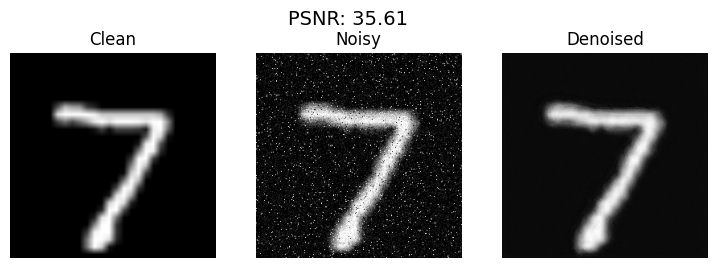

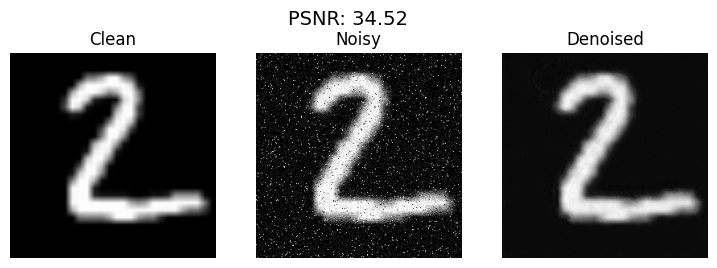

In [ ]:
# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# Noise Function
# ----------------------------
def add_noise(x, gaussian_std=0.1, sp_amount=0.02):
    x_noisy = x + torch.randn_like(x) * gaussian_std
    x_noisy = torch.clamp(x_noisy, 0, 1)
    B, C, H, W = x_noisy.shape
    num_sp = int(sp_amount * H * W)
    for i in range(B):
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 1.0  # Salt
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 0.0  # Pepper
    return x_noisy

# ----------------------------
# Dataset and Loader
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Train dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(Subset(train_dataset, range(1000)), batch_size=8, shuffle=True)

# Test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(Subset(test_dataset, range(10)), batch_size=2, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 10  # for demo, increase for real training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# Vanilla NN - MRI Images

In [ ]:
# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get all image files inside the folder
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")  # convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image   # no labels, just the image

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

# ----------------------------
# Split into train(10) / val(5) / test(5)
# ----------------------------
train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Found 20 MRI images


Found 20 MRI images
Epoch 1/20, Train Loss: 0.5891, Val Loss: 16198.8415
Epoch 2/20, Train Loss: 0.2320, Val Loss: 400.5886
Epoch 3/20, Train Loss: 0.0846, Val Loss: 5.9348
Epoch 4/20, Train Loss: 0.0353, Val Loss: 2.2940
Epoch 5/20, Train Loss: 0.0221, Val Loss: 0.5277
Epoch 6/20, Train Loss: 0.0165, Val Loss: 0.0255
Epoch 7/20, Train Loss: 0.0121, Val Loss: 0.0136
Epoch 8/20, Train Loss: 0.0089, Val Loss: 0.0099
Epoch 9/20, Train Loss: 0.0082, Val Loss: 0.0082
Epoch 10/20, Train Loss: 0.0068, Val Loss: 0.0063
Epoch 11/20, Train Loss: 0.0064, Val Loss: 0.0057
Epoch 12/20, Train Loss: 0.0059, Val Loss: 0.0054
Epoch 13/20, Train Loss: 0.0054, Val Loss: 0.0049
Epoch 14/20, Train Loss: 0.0056, Val Loss: 0.0047
Epoch 15/20, Train Loss: 0.0050, Val Loss: 0.0045
Epoch 16/20, Train Loss: 0.0053, Val Loss: 0.0045
Epoch 17/20, Train Loss: 0.0056, Val Loss: 0.0042
Epoch 18/20, Train Loss: 0.0048, Val Loss: 0.0044
Epoch 19/20, Train Loss: 0.0048, Val Loss: 0.0041
Epoch 20/20, Train Loss: 0.0051, 

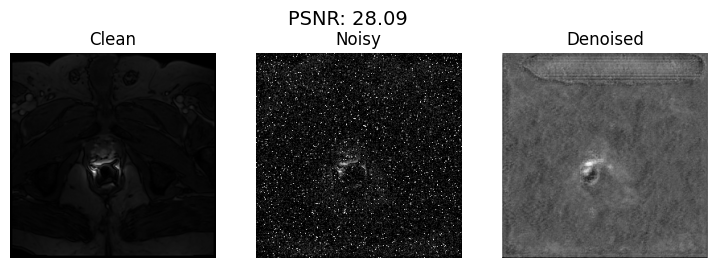

In [ ]:
# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get all image files inside the folder
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image   # no labels, just the image

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# Noise Function
# ----------------------------
def add_noise(x, gaussian_std=0.1, sp_amount=0.02):
    x_noisy = x + torch.randn_like(x) * gaussian_std
    x_noisy = torch.clamp(x_noisy, 0, 1)
    B, C, H, W = x_noisy.shape
    num_sp = int(sp_amount * H * W)
    for i in range(B):
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 1.0  # Salt
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 0.0  # Pepper
    return x_noisy

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

# Split into train(10) / val(5) / test(5)
train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 20  # for demo, increase for real training

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0
    for images in train_loader:   # only images now
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            val_loss += criterion(outputs, images).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# K-Space example

Printing a regular image and noisy image against its k-space representation

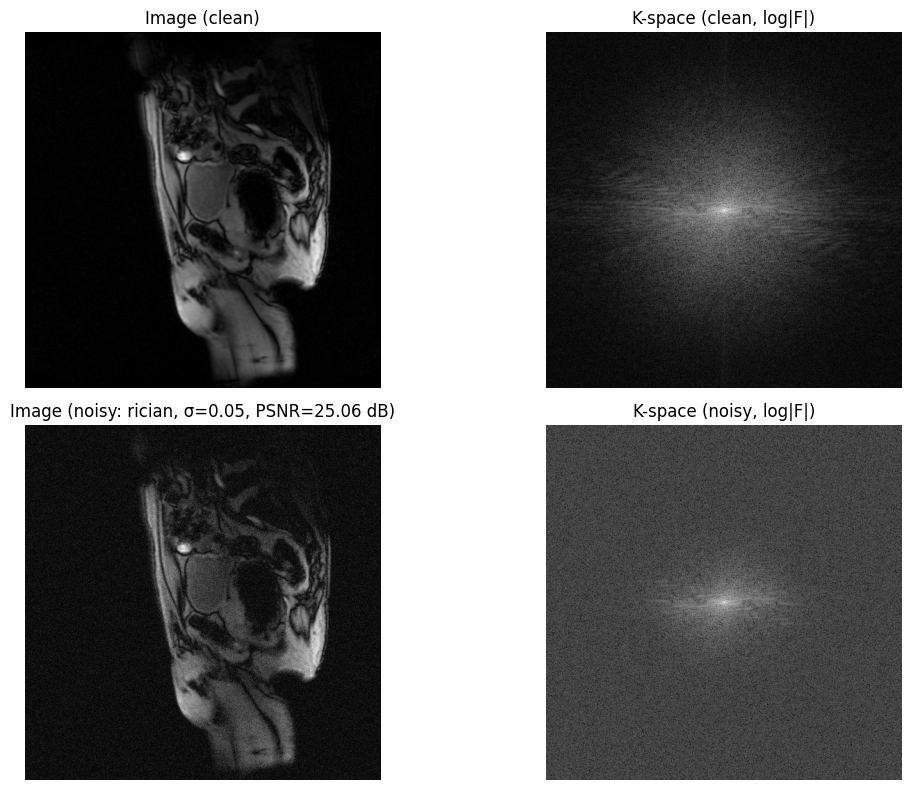

In [ ]:
# ----- paths -----
img_path = "example_image2.png"
os.makedirs("images", exist_ok=True)

# ----- load PNG -----
img = mpimg.imread(img_path)  # shape: (H,W) grayscale or (H,W,3/4) RGB(A)

# convert to float32 in [0,1]
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0
else:
    img = img.astype(np.float32)

# drop alpha if present
if img.ndim == 3 and img.shape[2] == 4:
    img = img[..., :3]

# convert to grayscale if RGB
if img.ndim == 3:
    # perceptual luminance weights
    img = img[..., 0]*0.2126 + img[..., 1]*0.7152 + img[..., 2]*0.0722

# optional normalization (keep dynamic range sane)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# ----- compute k-space for clean image -----
kspace = np.fft.fftshift(np.fft.fft2(img))
kspace_logmag = np.log1p(np.abs(kspace))

# ===== noise config =====
NOISE_TYPE = "rician"  # "gaussian" or "rician"
NOISE_STD = 0.05         # std in [0,1] image space
SEED = 42                # for reproducibility

rng = np.random.default_rng(SEED)

def add_gaussian_noise(x, sigma):
    n = rng.normal(loc=0.0, scale=sigma, size=x.shape).astype(np.float32)
    y = x + n
    return np.clip(y, 0.0, 1.0)

def add_rician_noise(x, sigma):
    # MRI-like noise: magnitude of two orthogonal Gaussian components
    n1 = rng.normal(0.0, sigma, size=x.shape).astype(np.float32)
    n2 = rng.normal(0.0, sigma, size=x.shape).astype(np.float32)
    y = np.sqrt((x + n1)**2 + n2**2)
    # rescale to [0,1] for viewing
    y = (y - y.min()) / (y.max() - y.min() + 1e-8)
    return np.clip(y, 0.0, 1.0)

# pick noise model
if NOISE_TYPE == "gaussian":
    img_noisy = add_gaussian_noise(img, NOISE_STD)
elif NOISE_TYPE == "rician":
    img_noisy = add_rician_noise(img, NOISE_STD)
else:
    raise ValueError("NOISE_TYPE must be 'gaussian' or 'rician'")

# ----- compute k-space for noisy image -----
kspace_noisy = np.fft.fftshift(np.fft.fft2(img_noisy))
kspace_noisy_logmag = np.log1p(np.abs(kspace_noisy))

# optional: compute PSNR for reference
mse = np.mean((img_noisy - img)**2)
psnr = 10.0 * np.log10(1.0 / (mse + 1e-12))

# ----- plot originals vs noisy -----
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Image (clean)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(kspace_logmag, cmap="gray")
plt.title("K-space (clean, log|F|)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img_noisy, cmap="gray")
plt.title(f"Image (noisy: {NOISE_TYPE}, σ={NOISE_STD}, PSNR={psnr:.2f} dB)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(kspace_noisy_logmag, cmap="gray")
plt.title("K-space (noisy, log|F|)")
plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join("images", "clean_vs_noisy_kspace.png"), dpi=200, bbox_inches="tight")
plt.show()


# Vanilla NN - MRI Images with K-space

Found 20 MRI images
Epoch 1/20, Train Loss: 0.4498, Val Loss: 0.0102
Epoch 2/20, Train Loss: 0.0893, Val Loss: 0.0241
Epoch 3/20, Train Loss: 0.0352, Val Loss: 0.0257
Epoch 4/20, Train Loss: 0.0207, Val Loss: 0.0094
Epoch 5/20, Train Loss: 0.0135, Val Loss: 0.0052
Epoch 6/20, Train Loss: 0.0102, Val Loss: 0.0046
Epoch 7/20, Train Loss: 0.0084, Val Loss: 0.0041
Epoch 8/20, Train Loss: 0.0093, Val Loss: 0.0041
Epoch 9/20, Train Loss: 0.0079, Val Loss: 0.0039
Epoch 10/20, Train Loss: 0.0071, Val Loss: 0.0038
Epoch 11/20, Train Loss: 0.0063, Val Loss: 0.0038
Epoch 12/20, Train Loss: 0.0059, Val Loss: 0.0038
Epoch 13/20, Train Loss: 0.0053, Val Loss: 0.0038
Epoch 14/20, Train Loss: 0.0060, Val Loss: 0.0038
Epoch 15/20, Train Loss: 0.0054, Val Loss: 0.0038
Epoch 16/20, Train Loss: 0.0045, Val Loss: 0.0040
Epoch 17/20, Train Loss: 0.0050, Val Loss: 0.0037
Epoch 18/20, Train Loss: 0.0057, Val Loss: 0.0036
Epoch 19/20, Train Loss: 0.0051, Val Loss: 0.0036
Epoch 20/20, Train Loss: 0.0041, Val Lo

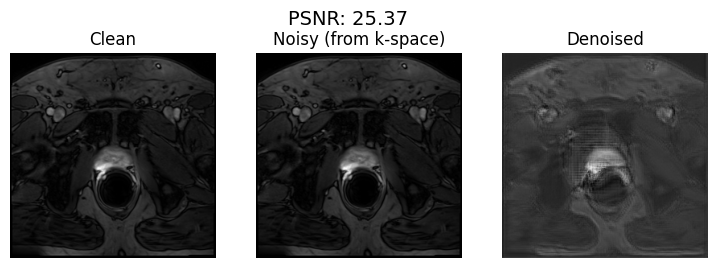

In [ ]:

# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image   # shape [1,H,W]

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    return psnr(clean_image.cpu().numpy(), denoised_image.cpu().numpy(), data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    return ssim(clean_image.cpu().numpy(), denoised_image.cpu().numpy(), data_range=1.0)

# ----------------------------
# K-space utilities
# ----------------------------
def fft2c(img):
    """ Apply centered 2D FFT (image -> kspace) """
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(img, dim=(-2,-1))), dim=(-2,-1))

def ifft2c(kspace):
    """ Apply centered 2D IFFT (kspace -> image) """
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(kspace, dim=(-2,-1))), dim=(-2,-1)).real

def add_kspace_noise(img, gaussian_std=0.02):
    """ Add Gaussian noise in k-space """
    kspace = fft2c(img)                       # [B,1,H,W] -> kspace
    noise = (torch.randn_like(kspace) + 1j*torch.randn_like(kspace)) * gaussian_std
    kspace_noisy = kspace + noise             # add complex noise
    img_noisy = ifft2c(kspace_noisy)          # back to image domain
    return torch.clamp(img_noisy, 0, 1)

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 20

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0
    for images in train_loader:
        images = images.to(device)                  # clean
        noisy_images = add_kspace_noise(images).to(device)  # noisy from k-space

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            noisy_images = add_kspace_noise(images).to(device)
            outputs = model(noisy_images)
            val_loss += criterion(outputs, images).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        noisy_images = add_kspace_noise(images).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy (from k-space)")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# DnCNN

https://github.com/yjn870/DnCNN-pytorch

In [ ]:
!git clone https://github.com/yjn870/DnCNN-pytorch.git

fatal: destination path 'DnCNN-pytorch' already exists and is not an empty directory.


Epoch 1/3, Loss: 0.0462
Epoch 2/3, Loss: 0.0078
Epoch 3/3, Loss: 0.0075


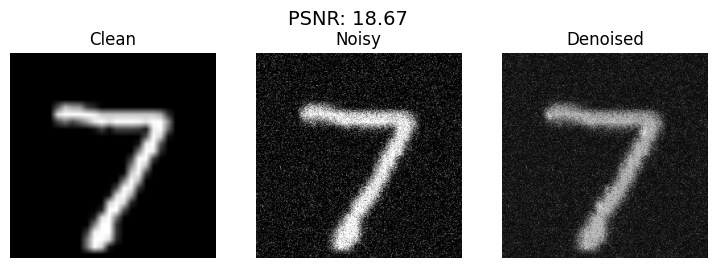

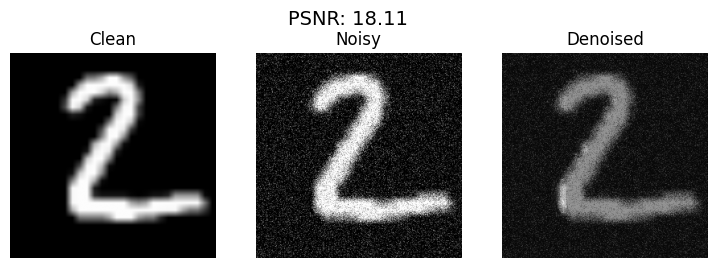

In [ ]:
# ----------------------------
# Imports
# ----------------------------
import sys
sys.path.append("./DnCNN_pytorch")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

from DnCNN_pytorch.model import DnCNN

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# Blind Gaussian Noise
# ----------------------------
def add_noise(x, sigma_range=(0, 55)):
    sigma = random.uniform(*sigma_range) / 255.0  # normalize to [0,1]
    noisy = x + torch.randn_like(x) * sigma
    return torch.clamp(noisy, 0, 1)

# ----------------------------
# Dataset and Loader
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(Subset(train_dataset, range(1000)), batch_size=8, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(Subset(test_dataset, range(10)), batch_size=2, shuffle=False)

# ----------------------------
# DnCNN-B Model
# ----------------------------
model = DnCNN(num_layers=20)  # from repo, hardcoded 17-layer blind Gaussian model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        # repeat grayscale to 3 channels for DnCNN-B
        images_3c = images.repeat(1, 3, 1, 1)
        noisy_images = add_noise(images_3c, sigma_range=(0, 55)).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images_3c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        images_3c = images.repeat(1, 3, 1, 1)
        noisy_images = add_noise(images_3c, sigma_range=(0, 55)).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break
